In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb  4 16:04:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from mlxtend.plotting import plot_confusion_matrix

import time
import os
import copy

In [ ]:
!nvidia-smi

Sat Feb  4 16:07:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## file processing

In [ ]:
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
##Run this
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
# !pip install --upgrade --no-cache-dir gdown

In [ ]:
##For main acc (sefatulwasi)
%cd /content/drive/MyDrive/ECG/Filtered_cwt/Split

/content/drive/MyDrive/ECG/Filtered_cwt/Split


In [ ]:
# pip install split-folders

In [ ]:
# import splitfolders

# splitfolders.ratio(input_directory, # The location of dataset
#                    output=output_directory, # The output location
#                    seed=1337, # The number of seed
#                    ratio=(.6, .2, .2), # The ratio of splited dataset
#                    group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
#                    move=False # If you choose to move, turn this into True
#                    )

In [ ]:
data_dir = "/content/drive/MyDrive/ECG/Filtered_cwt/Split/11"
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.ToTensor(),
    ]),

    VAL: transforms.Compose([
        transforms.ToTensor()
    ]),

    TEST: transforms.Compose([
        transforms.ToTensor()
    ])
}


image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x],
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=16,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}


dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 12699 images under train
Loaded 3627 images under val
Loaded 1816 images under test
Classes: 
['abnormal', 'normal']


In [ ]:
# loading the pretrained model from pytorch

vgg16 = models.vgg16_bn()
# print(vgg16.classifier[6].out_features)

ct = 0
for child in vgg16.children():
  ct += 1 
  if ct < 14:
    # freeze training for all layers until fc layers
    for param in vgg16.features.parameters():
      param.require_grad = False

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))]) 
vgg16.classifier = nn.Sequential(*features)

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
if use_gpu:
    vgg16.cuda()
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(vgg16.parameters(), lr=0.0001) 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0

    total_acc_train = []
    total_loss_train = []

    total_acc_val = []
    total_loss_val = []

    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0

        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            if i >= train_batches:
                break
                
            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs.cuda())
            
            _, preds = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        avg_loss = loss_train  / dataset_sizes[TRAIN]
        avg_acc = acc_train  / dataset_sizes[TRAIN]

        avg_loss = avg_loss.item()
        avg_acc = avg_acc.item()  

        total_acc_train.append(avg_acc)
        total_loss_train.append(avg_loss)

        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs.cuda())
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
            
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]

        avg_loss_val = avg_loss_val.item()
        avg_acc_val = avg_acc_val.item()         
        
        total_acc_val.append(avg_acc_val)
        total_loss_val.append(avg_loss_val)

        torch.cuda.empty_cache()

        total_df = pd.DataFrame()
        total_df['total_acc_train'] = np.array(total_acc_train)
        total_df['total_loss_train'] = np.array(total_loss_train)
        total_df['total_acc_val'] = np.array(total_acc_val)        
        total_df['total_loss_val'] = np.array(total_loss_val)

        total_df.to_csv("/content/drive/MyDrive/ECG/Filtered_cwt/Split/11_results/sample_total_vgg16.csv",index=False)



        
        print()
        print()
        print('----TRAINING SET RESULTS-----')
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg accuracy (train): {:.4f}".format(avg_acc))

        print()
        print('----VALIDATION SET RESULTS-----')
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    torch.cuda.empty_cache()
    print()
    print()
    print("Total accuracy (train): ")
    print(total_acc_train)
    print("Total loss (train): ")
    print(total_loss_train)
    print()
    epochs = range(1, num_epochs +1)
    plt.plot(epochs, total_loss_train, label = 'Training loss')
    plt.plot(epochs, total_loss_val, label = 'Validation loss')
    plt.title("Training and validation loss curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('/content/drive/MyDrive/ECG/Filtered_cwt/Split/11_results/TrainingVsVal_loss.png')
    plt.show()

    plt.plot(epochs, total_acc_train, label = 'Training accuracy')
    plt.plot(epochs, total_acc_val, label = 'Validation accuracy')
    plt.title("Training and validation accuracy curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('/content/drive/MyDrive/ECG/Filtered_cwt/Split/11_results/TrainingVsVal_acc.png')
    plt.show()

    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
torch.cuda.empty_cache()

Epoch 0/50
----------
Training batch 793/794
Validation batch 226/227

----TRAINING SET RESULTS-----
Epoch 0 result: 
Avg loss (train): 0.0509
Avg accuracy (train): 0.5548

----VALIDATION SET RESULTS-----
Avg loss (val): 0.0370
Avg acc (val): 0.7259
----------


Epoch 1/50
----------
Training batch 793/794
Validation batch 226/227

----TRAINING SET RESULTS-----
Epoch 1 result: 
Avg loss (train): 0.0357
Avg accuracy (train): 0.7189

----VALIDATION SET RESULTS-----
Avg loss (val): 0.0323
Avg acc (val): 0.7502
----------


Epoch 2/50
----------
Training batch 793/794
Validation batch 226/227

----TRAINING SET RESULTS-----
Epoch 2 result: 
Avg loss (train): 0.0341
Avg accuracy (train): 0.7379

----VALIDATION SET RESULTS-----
Avg loss (val): 0.0325
Avg acc (val): 0.7491
----------


Epoch 3/50
----------
Training batch 793/794
Validation batch 226/227

----TRAINING SET RESULTS-----
Epoch 3 result: 
Avg loss (train): 0.0331
Avg accuracy (train): 0.7471

----VALIDATION SET RESULTS-----
Avg lo

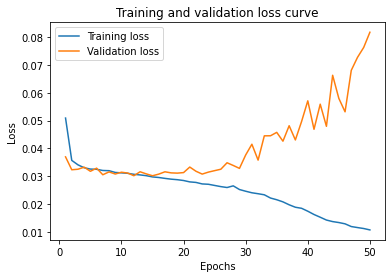

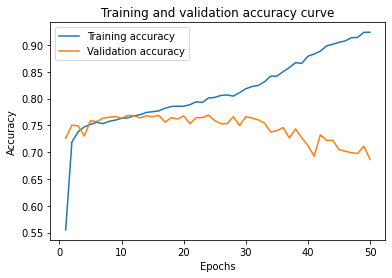

Training completed in 245m 48s
Best acc: 0.7690


In [ ]:
train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)
torch.cuda.empty_cache()
torch.save(vgg16.state_dict(), '/content/drive/MyDrive/ECG/Filtered_cwt/Split/11_results/vgg16.pt')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    running_total = 0.0
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    avg_precision = 0
    avg_recall = 0
    avg_f1 = 0
    avg_spec = 0
    
    precision_test = 0
    recall_test = 0
    f1_test = 0
    
    true_labels = []
    pred_labels = []

    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    with torch.no_grad():
      for i, data in enumerate(dataloaders[TEST]):
          if i % 100 == 0:
              print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

          vgg.train(False)
          vgg.eval()

          inputs, labels = data

          if use_gpu:
              inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
          else:
              inputs, labels = Variable(inputs), Variable(labels)

          nlabel = copy.deepcopy(labels)
          nlabel = nlabel.cpu().numpy()
          true_labels.extend(nlabel)
          outputs = vgg(inputs.cuda())
          
          _, preds = torch.max(outputs.data, 1)

          npreds = copy.deepcopy(preds)
          npreds = npreds.cpu().numpy()
          pred_labels.extend(npreds)
        
          running_total += labels.size(0)
          loss = criterion(outputs, labels)

          loss_test += loss.data
          acc_test += torch.sum(preds == labels.data)

          del inputs, labels, outputs, preds
          torch.cuda.empty_cache()
   
    print()   
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]

    precision_test += precision_score(true_labels, pred_labels, zero_division=1)
    recall_test += recall_score(true_labels, pred_labels, zero_division =1)
    f1_test += f1_score(true_labels, pred_labels, zero_division =1)


    # precision = precision_test  /  dataset_sizes[TEST]
    # recall = recall_test  /  dataset_sizes[TEST]
    # f1 = f1_test  /  dataset_sizes[TEST]


    # Build confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel()
    
    # df_cm = pd.DataFrame(cm/np.sum(cm), index = [i for i in class_names],
    #                     columns = [i for i in class_names])

    sns.heatmap(cm, cmap='Blues', fmt='', annot=True)
    plt.figure(figsize = (10,7))
    plt.savefig('/content/drive/MyDrive/ECG/Filtered_cwt/Split/11_results/conf_matrix.png')
    plt.show()


    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print("Precision: {:.4f}".format(precision_test))
    print("Recall: {:.4f}".format(recall_test))
    print("F1 Score: {:.4f}".format(f1_test))
    print('Confusion Matrix: ')
    print(cm)
    print('-' * 10)

In [ ]:
print("Test after training")
eval_model(vgg16, criterion)
torch.save(vgg16.state_dict(), '/content/drive/MyDrive/ECG/Filtered_cwt/Split/11_results/vgg16_eval_v2.pt')

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)